In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("SPb/SPb_addr_area_price_lon_lat.csv", sep=",")

In [3]:
df.head()

,address,area,price,longtitude,latitude
0,"Санкт-Петербург, ул. Подвойского, 26к3",82.4,140000,59.914628,30.481185
1,"Санкт-Петербург, Витебский пр-т, 15",37.2,169355,59.873505,30.347740
2,"Санкт-Петербург, пр-т Большой Сампсониевский, ...",31.5,139683,59.960183,30.345809
3,"Санкт-Петербург, ул. Маршала Захарова, 18к1",39.4,116751,59.857992,30.172057
4,"Санкт-Петербург, территория Усть-Славянка, Зав...",39.0,96154,59.832683,30.549116


In [4]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

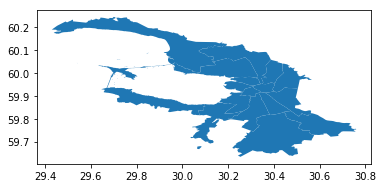

In [5]:
spb_street_map = gpd.read_file('exportsh/SPb/Saint Petersburg_AL5.shp', encoding="utf-8")
spb_street_map.plot()

In [6]:
spb_street_map.geometry

0     POLYGON ((29.4298103 60.1895376, 29.4519535 60...
1     POLYGON ((30.3633356 59.9138661, 30.3695106 59...
2     POLYGON ((30.2101343 59.972338, 30.2101532 59....
3     POLYGON ((30.070784 60.0962496, 30.0727589 60....
4     POLYGON ((30.2502295 59.9012907, 30.2502783 59...
5     POLYGON ((30.1778731 59.9443695, 30.1780783 59...
6     POLYGON ((30.3439759 59.9772694, 30.3440183 59...
7     POLYGON ((30.1614804 59.8742478, 30.1643533 59...
8     POLYGON ((30.4394362 59.8280282, 30.4415069 59...
9     POLYGON ((30.3942814 59.9290236, 30.3963299 59...
10    (POLYGON ((30.0349646 59.7178541, 30.0384198 5...
11    (POLYGON ((29.5394754 60.0440856, 29.5394984 6...
12    POLYGON ((30.1987721 59.8016053, 30.1990778 59...
13    POLYGON ((29.6475389 59.9298568, 29.6495068 59...
14    POLYGON ((29.9552652 60.0378207, 29.9552858 60...
15    POLYGON ((30.2182227 59.6730689, 30.219183 59....
16    POLYGON ((30.3325755 59.9130514, 30.3335212 59...
17    POLYGON ((30.308274 59.9410565, 30.3098903

{'init': 'epsg:4326'}


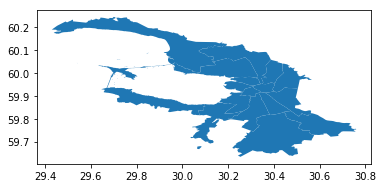

In [7]:
crs = {"init":"epsg:4326"}
#crs = {"init": "epsg:3857"}
spb_street_map_wm = spb_street_map.to_crs(crs)
print(spb_street_map_wm.crs)
spb_street_map_wm.plot()

In [8]:
spb_street_map_wm.geometry

0     POLYGON ((29.4298103 60.18953759999999, 29.451...
1     POLYGON ((30.3633356 59.91386610000001, 30.369...
2     POLYGON ((30.2101343 59.97233800000001, 30.210...
3     POLYGON ((30.070784 60.09624960000001, 30.0727...
4     POLYGON ((30.2502295 59.9012907, 30.2502783 59...
5     POLYGON ((30.1778731 59.9443695, 30.1780783 59...
6     POLYGON ((30.3439759 59.9772694, 30.3440183 59...
7     POLYGON ((30.1614804 59.8742478, 30.1643533 59...
8     POLYGON ((30.4394362 59.82802820000001, 30.441...
9     POLYGON ((30.3942814 59.9290236, 30.3963299 59...
10    (POLYGON ((30.0349646 59.7178541, 30.0384198 5...
11    (POLYGON ((29.5394754 60.0440856, 29.5394984 6...
12    POLYGON ((30.1987721 59.8016053, 30.1990778 59...
13    POLYGON ((29.6475389 59.9298568, 29.6495068 59...
14    POLYGON ((29.9552652 60.0378207, 29.9552858 60...
15    POLYGON ((30.2182227 59.6730689, 30.219183 59....
16    POLYGON ((30.3325755 59.91305139999999, 30.333...
17    POLYGON ((30.308274 59.9410565, 30.3098903

,address,area,price,longtitude,latitude,geometry
0,"Санкт-Петербург, ул. Подвойского, 26к3",82.4,140000,59.914628,30.481185,POINT (30.481185 59.914628)
1,"Санкт-Петербург, Витебский пр-т, 15",37.2,169355,59.873505,30.347740,POINT (30.34774 59.873505)
2,"Санкт-Петербург, пр-т Большой Сампсониевский, ...",31.5,139683,59.960183,30.345809,POINT (30.345809 59.960183)
3,"Санкт-Петербург, ул. Маршала Захарова, 18к1",39.4,116751,59.857992,30.172057,POINT (30.172057 59.857992)
4,"Санкт-Петербург, территория Усть-Славянка, Зав...",39.0,96154,59.832683,30.549116,POINT (30.549116 59.832683)
5,"Санкт-Петербург, пр-т Просвещения, 43",46.2,135281,60.046203,30.363084,POINT (30.363084 60.046203)
6,"Санкт-Петербург, Малый пр-т Васильевского остр...",69.1,212735,59.939951,30.250812,POINT (30.250812 59.939951)
7,"Санкт-Петербург, Мурино, Воронцовский б-р, 14к4",20.6,106311,60.061089,30.426711,POINT (30.426711 60.061089)
8,"Санкт-Петербург, Арцеуловская ал., д. 23, корп. 1",26.0,138077,60.042415,30.224716,POINT (30.224716 60.042415)
9,"Санкт-Петербург, б-р Головнина, 10",40.2,126866,59.936629,30.199680,POINT (30.19968 59.936629)


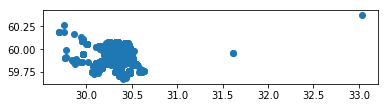

In [22]:
#geometry = [Point(xy) for xy in zip(df.latitude, df.longtitude)]
points = [Point(xy) for xy in zip(df.latitude, df.longtitude)]

geo_df = gpd.GeoDataFrame(df, geometry=points, crs=crs)
geo_df.plot()
geo_df

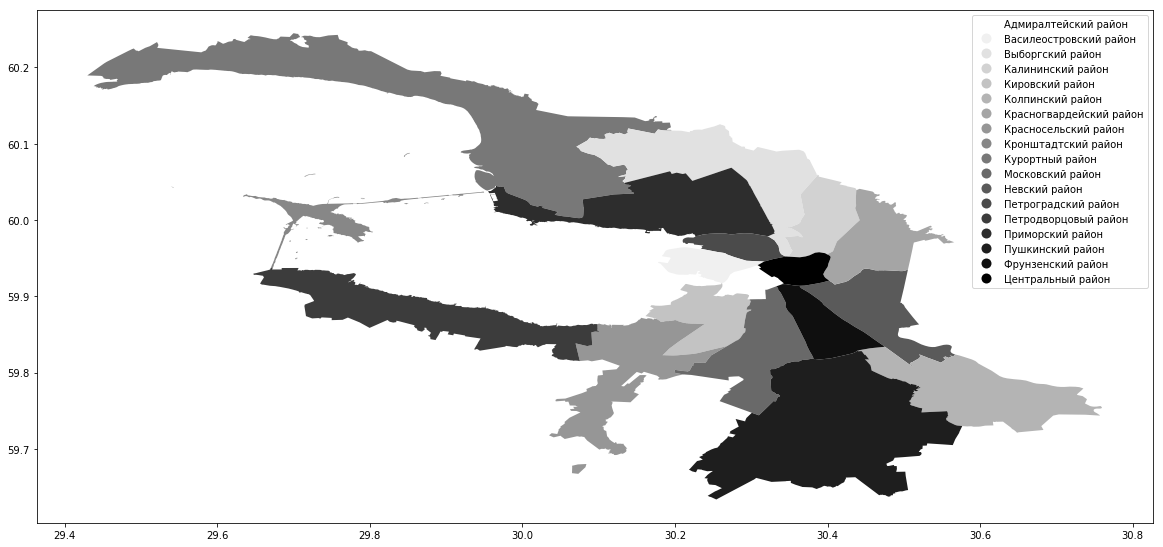

In [10]:
fig, ax = plt.subplots(figsize=(20,20))
spb_street_map_wm.plot(ax=ax, column = 'locname', linewidth=0.5, cmap='binary', legend=True)

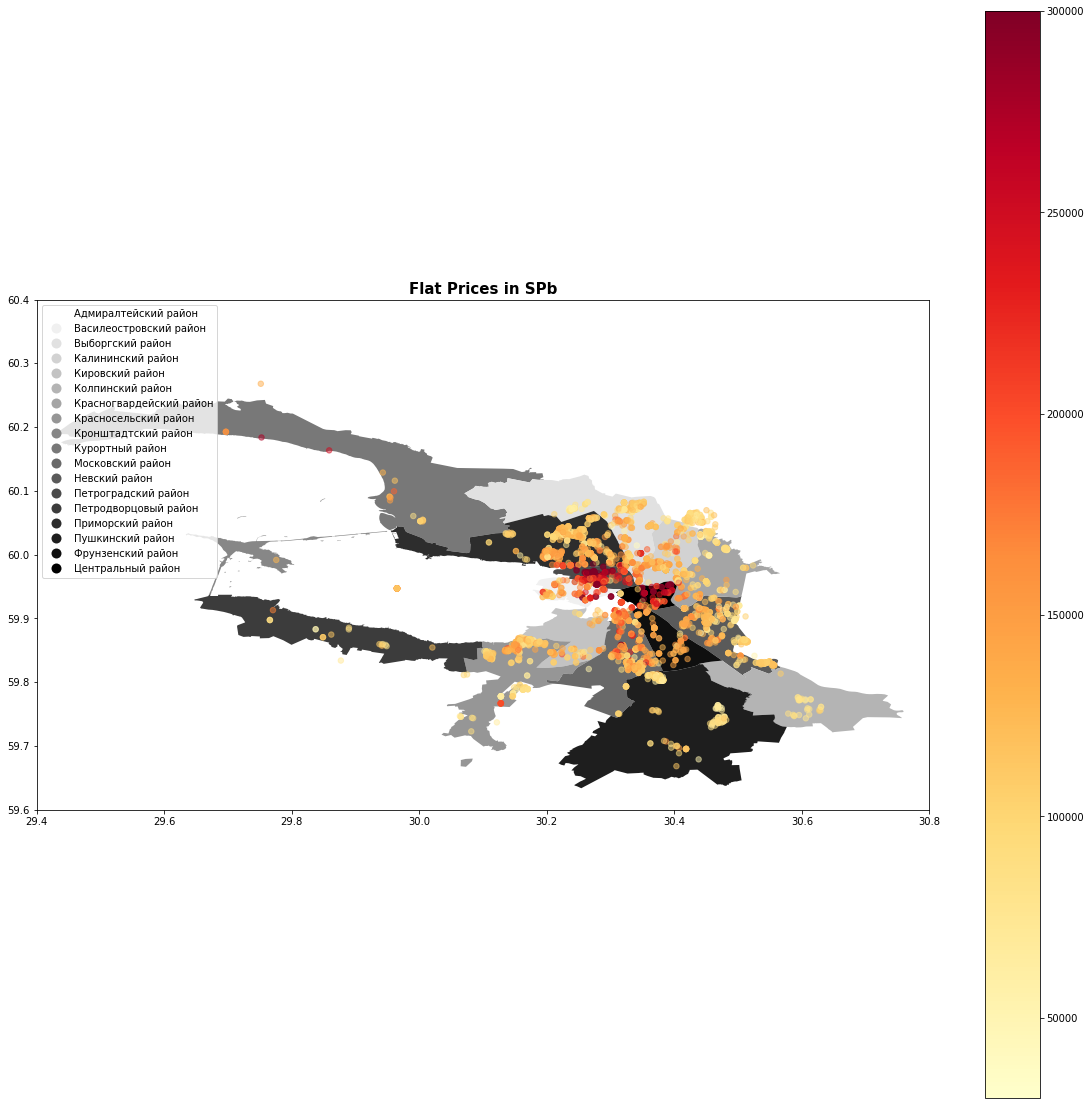

In [11]:
fig, ax = plt.subplots(figsize=(20,20))
spb_street_map_wm.plot(ax=ax, column = 'locname', linewidth=0.5, cmap='binary', legend=True)
geo_df.plot(column="price",ax=ax, alpha=0.5, legend=True, markersize=30, cmap="YlOrRd", vmin=30000, vmax=300000)
plt.title("Flat Prices in SPb", fontsize=15, fontweight="bold")
#plt.ylim(8320000,8460000)
#plt.xlim( 3280000,3420000)
plt.ylim(59.6, 60.4)
plt.xlim( 29.4, 30.8)
plt.show()

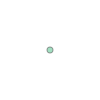

In [13]:
point = geo_df.geometry
point[1]

In [32]:
d = {}

for point in geo_df.geometry:    
    for i,_ in enumerate(spb_street_map):
        if point.within(spb_street_map.geometry[i]):
            if d.get(spb_street_map.locname[i], None) is None:
                d[spb_street_map_wm.locname[i]] = [geo_df.price[i]]
            else:
                d[spb_street_map_wm.locname[i]].append(geo_df.price[i])

In [33]:
from functools import reduce
sr_d = {}
for k, lst in d.items():
    sr_d[k] = reduce(lambda a, b: a + b, lst) / len(lst) 
    
sr_d

{'Невский район': 169355.0,
 'Московский район': 171250.0,
 'Выборгский район': 116751.0,
 'Красносельский район': 117845.0,
 'Василеостровский район': 135281.0,
 'Приморский район': 128608.0,
 'Калининский район': 212735.0,
 'Пушкинский район': 170000.0,
 'Петроградский район': 139683.0,
 'Петродворцовый район': 122727.0,
 'Адмиралтейский район': 96154.0,
 'Курортный район': 140000.0,
 'Красногвардейский район': 126866.0,
 'Кировский район': 106311.0,
 'Кронштадтский район': 120110.0,
 'Колпинский район': 138077.0}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text xticklabel objects>)

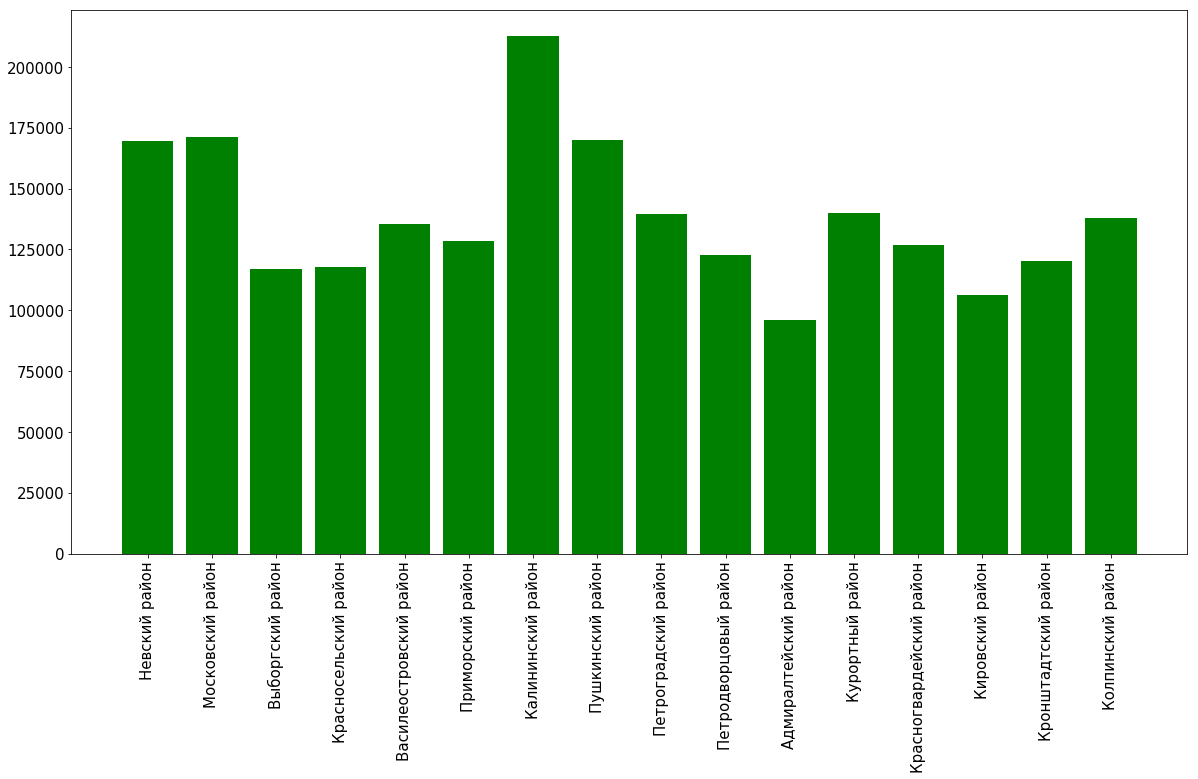

In [34]:
plt.figure(figsize=(20,10))
plt.bar(sr_d.keys(), sr_d.values(), color='g')
plt.tick_params(labelsize=15)
plt.xticks(rotation=90)

In [35]:
#  Визуализация по средней площади квартиры

In [42]:
d = {}

for point in geo_df.geometry:
    for i,_ in enumerate(spb_street_map):
        if point.within(spb_street_map.geometry[i]):
            if d.get(spb_street_map_wm.locname[i], None) is None:
                d[spb_street_map.locname[i]] = [geo_df["area"][i]]
            else:
                d[spb_street_map.locname[i]].append(geo_df["area"][i])

In [43]:
sr_d = {}
for k, lst in d.items():
    sr_d[k] = reduce(lambda a, b: a + b, lst) / len(lst) 
    
sr_d

{'Невский район': 37.20000000000029,
 'Московский район': 32.0,
 'Выборгский район': 39.399999999999764,
 'Красносельский район': 29.70000000000002,
 'Василеостровский район': 46.199999999999875,
 'Приморский район': 38.7999999999995,
 'Калининский район': 69.10000000000022,
 'Пушкинский район': 37.0,
 'Петроградский район': 31.5,
 'Петродворцовый район': 33.0,
 'Адмиралтейский район': 39.0,
 'Курортный район': 82.40000000000002,
 'Красногвардейский район': 40.19999999999997,
 'Кировский район': 20.600000000000005,
 'Кронштадтский район': 26.0,
 'Колпинский район': 26.0}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text xticklabel objects>)

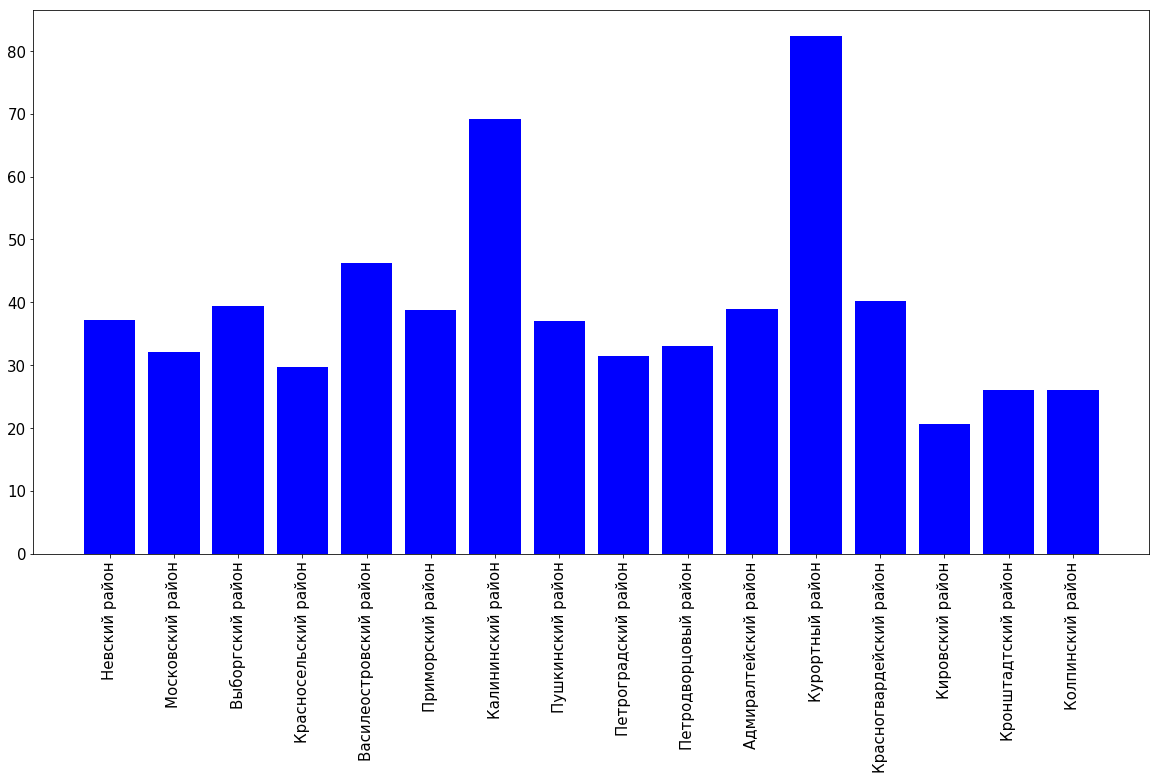

In [44]:
plt.figure(figsize=(20,10))
plt.bar(sr_d.keys(), sr_d.values(), color='b')
plt.tick_params(labelsize=15)
plt.xticks(rotation=90)